In [1]:
import pandas as pd
import numpy as np
import pymssql
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

f = open("D:/Github/Work/Tableau/datamart_password.txt", "r")
pw1 = f.readline()
pd.set_option("display.max_columns", None)
plt.style.use("dark_background")
fpath = "C:/Windows/Fonts/malgun.ttf"
font_name = mpl.font_manager.FontProperties(fname=fpath).get_name()
mpl.rc("font", family=font_name)

In [2]:
conn = pymssql.connect(server="133.186.215.165", database="HDCMART", user="hdcmart_user", password=pw1, charset="UTF8")
query = f"""
SELECT id_sabun AS num, ds_hname AS name, ds_email AS email, ds_bonbu AS hq, ds_dept AS dept, ds_occupation AS job, DS_EMPTYPE AS sub
FROM DATAMART_DAAV_BASEINFO_DETAIL_ALL
where cd_corp = 'A101' and ds_retire = '재직';
"""
hr = pd.read_sql(query, conn)
hr.columns = hr.columns.str.lower()
for col in hr.columns:
    if pd.api.types.is_string_dtype(hr[col]):
        hr[col] = hr[col].str.encode("latin-1", errors="ignore").str.decode("euc-kr", errors="ignore")

hr["num"] = hr["num"].astype("str")

# 전체

In [58]:
usage = pd.read_csv("Views_전체.csv")

usage["username"] = usage["username"].astype("str")
usage["created_at_local"] = usage["created_at_local"].str.replace("오전", "AM").str.replace("오후", "PM")
usage["Created At"] = usage["created_at_local"].str.replace("오전", "AM").str.replace("오후", "PM")
usage["created_at_local"] = pd.to_datetime(usage["created_at_local"], format="%Y-%m-%d %p %I:%M:%S")
usage["Created At"] = pd.to_datetime(usage["created_at_local"], format="%Y-%m-%d %p %I:%M:%S")
usage = usage[usage["created_at_local"]>="2021-11-08"]
usage = usage.rename({"Name (Hist Workbooks)":"lvl1", "Name (Hist Views)":"lvl2"}, axis=1)
usage = usage[usage["name (hist_projects)"]=="EIS"]

In [65]:
data = pd.merge(usage, hr, left_on="username", right_on="num")
data["wb"] = data["lvl1"] + "-" + data["lvl2"]

data = data[["lvl1", "lvl2", "hq", "dept", "name"]]
# data2 = data[~data["username"].isin(["5899", "4100435", "5947", "6363", "5634", "4001380", "6448"])]

In [66]:
data.head()

,lvl1,lvl2,hq,dept,name
0,본부장 회의,회의자료,건설본부,건설본부,하원기
1,본부장 회의,회의자료,건설본부,건설본부,하원기
2,본부장 회의,회의자료,건설본부,건설본부,하원기
3,본부장 회의,회의자료,건설본부,건설본부,하원기
4,현장,메인,건설본부,건설본부,하원기


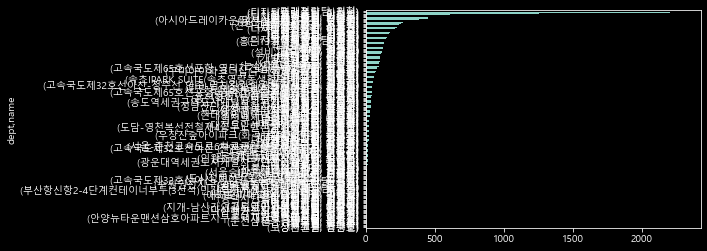

In [67]:
data.groupby(["dept", "name"]).size().sort_values().plot.barh();

# Pivot Table

In [110]:
pivot = pd.pivot_table(data, index=["name"], columns=["lvl1", "lvl2"], values="Number of Records", aggfunc="sum", fill_value=0, margins=True)
pivot = pivot.sort_values(["All"], ascending=False)
pivot = pivot.sort_values([("All", "")], axis=1, ascending=False)
# pivot.to_csv("D:/pivot.csv", encoding=False)

# Normalized Pivot Table

In [114]:
pivot = pd.pivot_table(data, index=["name"], columns=["lvl1", "lvl2"], values="Number of Records", aggfunc="sum", fill_value=0, margins=True)
pivot = pivot.sort_values(["All"], ascending=False)
# pivot = pivot.sort_values([("All", "")], axis=1, ascending=False)
pivot = pivot.sort_values([("All")], axis=1, ascending=False)
pivot = pivot.iloc[1:, 1:]

user_bias = pivot.sum(axis=1)
pivot_norm_user = pivot.div(user_bias, axis=0)
pivot_norm_user = round(pivot_norm_user*100, 1)
# pivot_norm_user.to_csv("D:/pivot_norm_user.csv", encoding=False)

In [68]:
# arr = np.array(pivot)
# global_bias = np.sum(arr)/(arr.shape[0]*arr.shape[1])
# user_bias = pivot.mean(axis=1) - global_bias
# item_bias = pivot.mean(axis=0) - global_bias
# pivot = pivot.sub(user_bias, axis=0).sub(item_bias, axis=1)

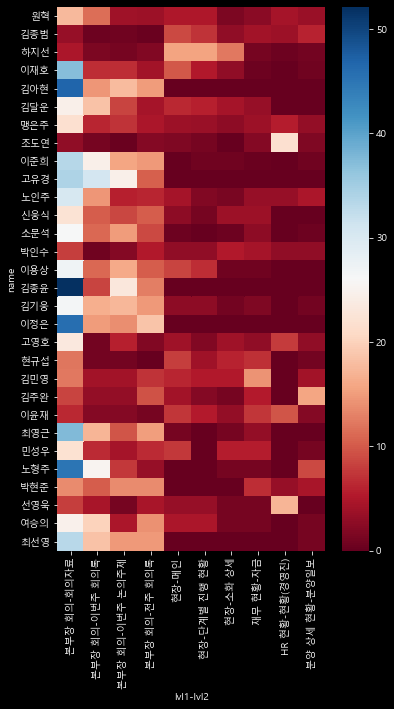

In [117]:
temp = pivot_norm_user.iloc[:30, :10]
fig, axes = plt.subplots(figsize=(6, 10))
sb.heatmap(temp, annot=False, cmap="RdBu");

# Grouping by User

In [183]:
gby_user = data2.groupby(["username", "dept", "name"], as_index=False).size().sort_values(["size"], ascending=False)
gby_user.to_csv("D:/gby_user.csv", encoding="euc-kr", index=False)
gby_user.head(20)

,username,dept,name,size
69,6281,안전경영실,고유경,90
55,6012,미래전략팀,김종윤,86
35,5011,견적그룹(개발영업),소문석,85
74,6333,공정상생팀,김관빈,66
28,4825,당진아이파크,신웅식,65
85,6443,미래혁신본부,고영호,56
56,6032,디지털플랫폼팀,박현준,52
5,3767,아시아드레이카운티(부산거제2구역),김달운,51
9,3919,홍은13구역재개발,이용상,50
37,5207,용산병원프로젝트,이준희,48


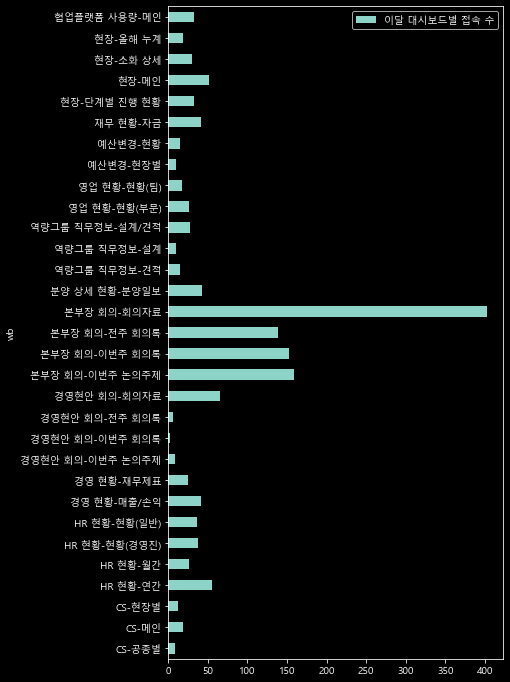

In [185]:
gby_wb = data2.groupby(["wb"], as_index=False).size()
gby_wb = gby_wb.sort_values(["size"])
gby_wb = gby_wb.sort_values(["wb"])

gby_wb.plot.barh(x="wb", y="size", label="이달 대시보드별 접속 수", figsize=(6, 12));

In [ ]:
gby_wb = data2.groupby(["Name (Hist Workbooks)"], as_index=False).size()
gby_wb = gby_wb.sort_values(["size"])
# gby_wb = gby_wb.sort_values(["Name (Hist Workbooks)"])

gby_wb.plot.barh(x="Name (Hist Workbooks)", y="size", label="이달 대시보드별 접속 수", figsize=(6, 6));

# 안전

In [18]:
usage = pd.read_csv("안전.csv")

usage["username"] = usage["username"].astype("str")
usage["created_at_local"] = usage["created_at_local"].str.replace("오전", "AM").str.replace("오후", "PM")
# usage["Created At"] = usage["created_at_local"].str.replace("오전", "AM").str.replace("오후", "PM")
usage["created_at_local"] = pd.to_datetime(usage["created_at_local"], format="%Y-%m-%d %p %I:%M:%S")
# usage["Created At"] = pd.to_datetime(usage["created_at_local"], format="%Y-%m-%d %p %I:%M:%S")
# usage = usage[usage["created_at_local"]>="2021-11-08"]
usage = usage.rename({"Name (Hist Workbooks)":"lvl1", "Name (Hist Views)":"lvl2"}, axis=1)
# usage = usage[usage["name (hist_projects)"]=="EIS"]
usage = usage[(~usage["username"].isin(["5947", "6363"]))]

In [20]:
data = pd.merge(usage, hr, left_on="username", right_on="num")
# data["wb"] = data["lvl1"] + "-" + data["lvl2"]

data = data[["created_at_local", "lvl1", "lvl2", "num", "hq", "dept", "name"]]
# data2 = data[~data["username"].isin(["5899", "4100435", "5947", "6363", "5634", "4001380", "6448"])]

In [22]:
data.head()

,created_at_local,lvl1,lvl2,num,hq,dept,name
0,2022-03-10 13:10:39,안전 현황,재해 현황,6443,미래혁신본부,미래혁신본부,고영호
1,2022-03-10 13:13:33,안전 현황,재해 추이,6443,미래혁신본부,미래혁신본부,고영호
2,2022-03-10 13:15:03,안전 현황,재해 현황,6443,미래혁신본부,미래혁신본부,고영호
3,2022-03-10 13:15:16,안전 현황,재해 추이,6443,미래혁신본부,미래혁신본부,고영호
4,2022-03-10 13:15:22,안전 현황,재해 현황,6443,미래혁신본부,미래혁신본부,고영호


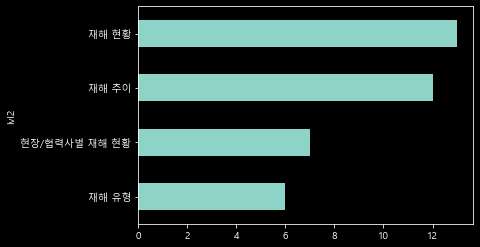

In [31]:
data.groupby(["lvl2"]).size().sort_values().plot.barh();

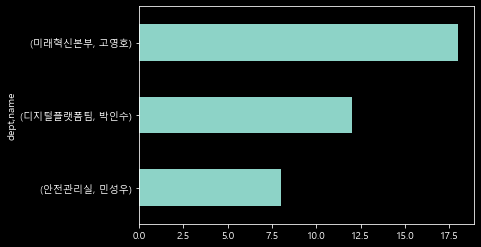

In [44]:
data.groupby(["dept", "name"]).size().sort_values().plot.barh();

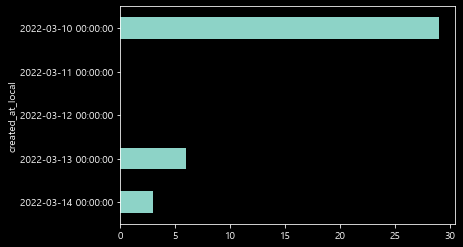

In [57]:
data.groupby(pd.Grouper(key="created_at_local", freq="D")).size().iloc[::-1].plot.barh();